In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import export_graphviz
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler


import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

import acquire


In [2]:
df = acquire.get_telco_data()

In [3]:
df.head()

,customer_id,gender,senior_citizen,partner,dependents,tenure,monthly_charges,total_charges,phone_service,multiple_lines,...,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,paperless_billing,contract_type_id,payment_type_id,internet_service_type_id,churn
0,0002-ORFBO,Female,0,Yes,Yes,9,65.6,593.3,Yes,No,...,Yes,No,Yes,Yes,No,Yes,2,2,1,No
1,0003-MKNFE,Male,0,No,No,9,59.9,542.4,Yes,Yes,...,No,No,No,No,Yes,No,1,2,1,No
2,0004-TLHLJ,Male,0,No,No,4,73.9,280.85,Yes,No,...,No,Yes,No,No,No,Yes,1,1,2,Yes
3,0011-IGKFF,Male,1,Yes,No,13,98.0,1237.85,Yes,No,...,Yes,Yes,No,Yes,Yes,Yes,1,1,2,Yes
4,0013-EXCHZ,Female,1,Yes,No,3,83.9,267.4,Yes,No,...,No,No,Yes,Yes,No,Yes,1,2,2,Yes


In [4]:
df.shape

(7043, 21)

In [5]:
# Check for nulls in the columns of interest
assert df.total_charges.isna().sum() == 0, "There are missing values in this column. Handle them before proceeding"
assert df.monthly_charges.isna().sum() == 0, "There are missing values in this column. Handle them before proceeding"
assert df.tenure.isna().sum() == 0, "There are missing values in this column. Handle them before proceeding"

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
customer_id                 7043 non-null object
gender                      7043 non-null object
senior_citizen              7043 non-null int64
partner                     7043 non-null object
dependents                  7043 non-null object
tenure                      7043 non-null int64
monthly_charges             7043 non-null float64
total_charges               7043 non-null object
phone_service               7043 non-null object
multiple_lines              7043 non-null object
online_security             7043 non-null object
online_backup               7043 non-null object
device_protection           7043 non-null object
tech_support                7043 non-null object
streaming_tv                7043 non-null object
streaming_movies            7043 non-null object
paperless_billing           7043 non-null object
contract_type_id            7043 non-null int64
payment_type_

In [7]:
#why is total_charges an object?
df.total_charges.value_counts(dropna=False)

           11
20.2       11
19.75       9
19.9        8
19.65       8
           ..
199.75      1
3480.35     1
825.1       1
583.3       1
2603.95     1
Name: total_charges, Length: 6531, dtype: int64

- It looks like there are 11 observations where the total_charges is an empty string
- Need to change total_charges to a float

In [8]:
# Make any string with multiple spaces into an empty space value
df.total_charges = df.total_charges.str.strip()

# Count the number of empty string entries
df[df.total_charges == ""]

,customer_id,gender,senior_citizen,partner,dependents,tenure,monthly_charges,total_charges,phone_service,multiple_lines,...,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,paperless_billing,contract_type_id,payment_type_id,internet_service_type_id,churn
945,1371-DWPAZ,Female,0,Yes,Yes,0,56.05,,No,No phone service,...,Yes,Yes,Yes,Yes,No,No,3,4,1,No
1731,2520-SGTTA,Female,0,Yes,Yes,0,20.00,,Yes,No,...,No internet service,No internet service,No internet service,No internet service,No internet service,No,3,2,3,No
1906,2775-SEFEE,Male,0,No,Yes,0,61.90,,Yes,Yes,...,Yes,No,Yes,No,No,Yes,3,3,1,No
2025,2923-ARZLG,Male,0,Yes,Yes,0,19.70,,Yes,No,...,No internet service,No internet service,No internet service,No internet service,No internet service,Yes,2,2,3,No
2176,3115-CZMZD,Male,0,No,Yes,0,20.25,,Yes,No,...,No internet service,No internet service,No internet service,No internet service,No internet service,No,3,2,3,No
2250,3213-VVOLG,Male,0,Yes,Yes,0,25.35,,Yes,Yes,...,No internet service,No internet service,No internet service,No internet service,No internet service,No,3,2,3,No
2855,4075-WKNIU,Female,0,Yes,Yes,0,73.35,,Yes,Yes,...,Yes,Yes,Yes,Yes,No,No,3,2,1,No
3052,4367-NUYAO,Male,0,Yes,Yes,0,25.75,,Yes,Yes,...,No internet service,No internet service,No internet service,No internet service,No internet service,No,3,2,3,No
3118,4472-LVYGI,Female,0,Yes,Yes,0,52.55,,No,No phone service,...,No,Yes,Yes,Yes,No,Yes,3,3,1,No
4054,5709-LVOEQ,Female,0,Yes,Yes,0,80.85,,Yes,No,...,Yes,Yes,No,Yes,Yes,No,3,2,1,No


It looks like those values are blank bc the tenure is 0. I will change it to 1 since they were probably customers for about a month

In [9]:
df.tenure.value_counts().sort_index()

0      11
1     613
2     238
3     200
4     176
     ... 
68    100
69     95
70    119
71    170
72    362
Name: tenure, Length: 73, dtype: int64

In [10]:
# Replace any tenures of 0 with 1

df.tenure.replace(0, 1, inplace=True)
# # Validate my tenure count for value 1

df.tenure.value_counts().sort_index()

1     624
2     238
3     200
4     176
5     133
     ... 
68    100
69     95
70    119
71    170
72    362
Name: tenure, Length: 72, dtype: int64

In [11]:
df[df.tenure == 1]

,customer_id,gender,senior_citizen,partner,dependents,tenure,monthly_charges,total_charges,phone_service,multiple_lines,...,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,paperless_billing,contract_type_id,payment_type_id,internet_service_type_id,churn
17,0021-IKXGC,Female,1,No,No,1,72.10,72.1,Yes,Yes,...,No,No,No,No,No,Yes,1,1,2,No
19,0023-HGHWL,Male,1,No,No,1,25.10,25.1,No,No phone service,...,No,No,No,No,No,Yes,1,1,1,Yes
25,0032-PGELS,Female,0,Yes,Yes,1,30.50,30.5,No,No phone service,...,No,No,No,No,No,No,1,3,1,Yes
48,0082-LDZUE,Male,0,No,No,1,44.30,44.3,Yes,No,...,No,No,No,No,No,Yes,1,2,1,No
63,0107-WESLM,Male,0,No,No,1,19.85,19.85,Yes,No,...,No internet service,No internet service,No internet service,No internet service,No internet service,Yes,1,1,3,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6980,9907-SWKKF,Female,1,No,No,1,25.05,25.05,No,No phone service,...,No,No,No,No,No,No,1,2,1,Yes
7007,9940-RHLFB,Female,0,No,No,1,75.30,75.3,Yes,No,...,No,Yes,No,No,No,No,1,1,2,Yes
7021,9962-BFPDU,Female,0,Yes,Yes,1,20.05,20.05,Yes,No,...,No internet service,No internet service,No internet service,No internet service,No internet service,No,1,2,3,No
7033,9975-SKRNR,Male,0,No,No,1,18.90,18.9,Yes,No,...,No internet service,No internet service,No internet service,No internet service,No internet service,No,1,2,3,No


In [12]:
# Replace the blank total_charges with the monthly_charge for tenure == 1
df.total_charges.replace('', df.monthly_charges, inplace=True)

In [13]:
# Validate my changes
df[df.tenure == 1]

,customer_id,gender,senior_citizen,partner,dependents,tenure,monthly_charges,total_charges,phone_service,multiple_lines,...,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,paperless_billing,contract_type_id,payment_type_id,internet_service_type_id,churn
17,0021-IKXGC,Female,1,No,No,1,72.10,72.1,Yes,Yes,...,No,No,No,No,No,Yes,1,1,2,No
19,0023-HGHWL,Male,1,No,No,1,25.10,25.1,No,No phone service,...,No,No,No,No,No,Yes,1,1,1,Yes
25,0032-PGELS,Female,0,Yes,Yes,1,30.50,30.5,No,No phone service,...,No,No,No,No,No,No,1,3,1,Yes
48,0082-LDZUE,Male,0,No,No,1,44.30,44.3,Yes,No,...,No,No,No,No,No,Yes,1,2,1,No
63,0107-WESLM,Male,0,No,No,1,19.85,19.85,Yes,No,...,No internet service,No internet service,No internet service,No internet service,No internet service,Yes,1,1,3,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6980,9907-SWKKF,Female,1,No,No,1,25.05,25.05,No,No phone service,...,No,No,No,No,No,No,1,2,1,Yes
7007,9940-RHLFB,Female,0,No,No,1,75.30,75.3,Yes,No,...,No,Yes,No,No,No,No,1,1,2,Yes
7021,9962-BFPDU,Female,0,Yes,Yes,1,20.05,20.05,Yes,No,...,No internet service,No internet service,No internet service,No internet service,No internet service,No,1,2,3,No
7033,9975-SKRNR,Male,0,No,No,1,18.90,18.9,Yes,No,...,No internet service,No internet service,No internet service,No internet service,No internet service,No,1,2,3,No


In [14]:
df.total_charges = df.total_charges.astype(float)

In [15]:
def wrangle_telco():
    df = acquire.get_telco_data()
    df.tenure.replace(0, 1, inplace=True)
    df.total_charges = df.total_charges.str.strip()
    df.total_charges.replace('', df.monthly_charges, inplace=True)
    df.total_charges = df.total_charges.astype(float)
    df['automatic_payment'] = ((df['payment_type_id'] == 3) | (df['payment_type_id'] == 4))
    scaler = MinMaxScaler()
    df['total_charges_scaled'] = scaler.fit_transform(df['total_charges'].values.reshape(-1,1))
    return df

In [61]:
df = wrangle_telco()
df.head()

,customer_id,gender,senior_citizen,partner,dependents,tenure,monthly_charges,total_charges,phone_service,multiple_lines,...,tech_support,streaming_tv,streaming_movies,paperless_billing,contract_type_id,payment_type_id,internet_service_type_id,churn,automatic_payment,total_charges_scaled
0,0002-ORFBO,Female,0,Yes,Yes,9,65.6,593.30,Yes,No,...,Yes,Yes,No,Yes,2,2,1,No,False,0.066294
1,0003-MKNFE,Male,0,No,No,9,59.9,542.40,Yes,Yes,...,No,No,Yes,No,1,2,1,No,False,0.060420
2,0004-TLHLJ,Male,0,No,No,4,73.9,280.85,Yes,No,...,No,No,No,Yes,1,1,2,Yes,False,0.030239
3,0011-IGKFF,Male,1,Yes,No,13,98.0,1237.85,Yes,No,...,No,Yes,Yes,Yes,1,1,2,Yes,False,0.140670
4,0013-EXCHZ,Female,1,Yes,No,3,83.9,267.40,Yes,No,...,Yes,Yes,No,Yes,1,2,2,Yes,False,0.028687


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 23 columns):
customer_id                 7043 non-null object
gender                      7043 non-null object
senior_citizen              7043 non-null int64
partner                     7043 non-null object
dependents                  7043 non-null object
tenure                      7043 non-null int64
monthly_charges             7043 non-null float64
total_charges               7043 non-null float64
phone_service               7043 non-null object
multiple_lines              7043 non-null object
online_security             7043 non-null object
online_backup               7043 non-null object
device_protection           7043 non-null object
tech_support                7043 non-null object
streaming_tv                7043 non-null object
streaming_movies            7043 non-null object
paperless_billing           7043 non-null object
contract_type_id            7043 non-null int64
payment_type

In [18]:
# step 1 split
train, test = train_test_split(df, random_state=123, train_size=.86)

In [19]:
# step 2 for loop w/ list of columns to encode
encoder = LabelEncoder()

encode_list = [
    'gender', 'partner', 'dependents', 'phone_service'
    , 'multiple_lines', 'online_security', 'online_backup'
    , 'device_protection', 'tech_support'
    , 'streaming_movies', 'streaming_tv', 'paperless_billing', 'churn'
    ]
               
               
               
for e in encode_list:
    train[e] = encoder.fit_transform(train[e])
    test[e] = encoder.transform(test[e])

In [20]:
train.head()

,customer_id,gender,senior_citizen,partner,dependents,tenure,monthly_charges,total_charges,phone_service,multiple_lines,...,tech_support,streaming_tv,streaming_movies,paperless_billing,contract_type_id,payment_type_id,internet_service_type_id,churn,automatic_payment,total_charges_scaled
2364,3389-KTRXV,0,0,1,1,23,23.85,625.65,1,2,...,1,1,1,0,3,2,3,0,False,0.070027
6550,9300-RENDD,1,0,0,0,1,79.95,79.95,1,0,...,0,2,0,1,1,1,2,1,False,0.007056
1971,2853-CWQFQ,1,0,0,1,1,59.55,59.55,1,0,...,2,0,2,1,1,2,1,0,False,0.004702
335,0495-RVCBF,0,0,0,0,1,79.70,79.70,1,0,...,0,0,2,1,1,1,2,1,False,0.007027
5662,7979-CORPM,1,0,0,0,24,90.55,2282.55,1,2,...,0,2,0,1,1,4,2,1,True,0.261222


In [21]:
train.shape

(6056, 23)

In [22]:
test.shape

(987, 23)

In [23]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6056 entries, 2364 to 3582
Data columns (total 23 columns):
customer_id                 6056 non-null object
gender                      6056 non-null int64
senior_citizen              6056 non-null int64
partner                     6056 non-null int64
dependents                  6056 non-null int64
tenure                      6056 non-null int64
monthly_charges             6056 non-null float64
total_charges               6056 non-null float64
phone_service               6056 non-null int64
multiple_lines              6056 non-null int64
online_security             6056 non-null int64
online_backup               6056 non-null int64
device_protection           6056 non-null int64
tech_support                6056 non-null int64
streaming_tv                6056 non-null int64
streaming_movies            6056 non-null int64
paperless_billing           6056 non-null int64
contract_type_id            6056 non-null int64
payment_type_id      

In [24]:
# How many people have churned?
train.churn.value_counts()

0    4457
1    1599
Name: churn, dtype: int64

Let's try to narrow down which features have an effect on churn
try a .corr 

In [25]:
train.corr()

,gender,senior_citizen,partner,dependents,tenure,monthly_charges,total_charges,phone_service,multiple_lines,online_security,...,tech_support,streaming_tv,streaming_movies,paperless_billing,contract_type_id,payment_type_id,internet_service_type_id,churn,automatic_payment,total_charges_scaled
gender,1.000000,-0.001563,-0.010743,0.009251,0.000150,-0.015957,-0.005455,0.002390,-0.011607,-0.017625,...,-0.002708,-0.007125,-0.009451,-0.017796,0.001289,-0.001275,0.005485,-0.003737,-0.015270,-0.005455
senior_citizen,-0.001563,1.000000,0.013353,-0.213133,0.007996,0.212309,0.091511,0.007069,0.139327,-0.121353,...,-0.152216,0.018795,0.035927,0.153468,-0.142456,-0.094226,-0.027452,0.153125,-0.034329,0.091511
partner,-0.010743,0.013353,1.000000,0.456137,0.381990,0.106660,0.321563,0.024960,0.147918,0.139039,...,0.127154,0.138178,0.128912,-0.006611,0.291634,0.133019,-0.002402,-0.148242,0.163250,0.321563
dependents,0.009251,-0.213133,0.456137,1.000000,0.169414,-0.104814,0.072801,0.000692,-0.020852,0.145128,...,0.134716,0.052112,0.023455,-0.112460,0.243763,0.128340,0.039866,-0.167377,0.097516,0.072801
tenure,0.000150,0.007996,0.381990,0.169414,1.000000,0.246675,0.826808,0.012341,0.341842,0.324420,...,0.324882,0.288364,0.296674,0.012589,0.672392,0.336784,-0.030717,-0.355771,0.394938,0.826808
monthly_charges,-0.015957,0.212309,0.106660,-0.104814,0.246675,1.000000,0.649936,0.245421,0.430870,-0.051944,...,-0.005559,0.332700,0.340085,0.349390,-0.072094,-0.074962,-0.320980,0.190344,0.061651,0.649936
total_charges,-0.005455,0.091511,0.321563,0.072801,0.826808,0.649936,1.000000,0.113627,0.451287,0.252795,...,0.279102,0.388519,0.398868,0.161746,0.449880,0.222421,-0.176330,-0.203771,0.308436,1.000000
phone_service,0.002390,0.007069,0.024960,0.000692,0.012341,0.245421,0.113627,1.000000,-0.023653,-0.029950,...,-0.023352,0.050536,0.043209,0.011636,0.001485,-0.006474,0.383449,0.009418,0.001288,0.113627
multiple_lines,-0.011607,0.139327,0.147918,-0.020852,0.341842,0.430870,0.451287,-0.023653,1.000000,0.014246,...,0.013327,0.170305,0.184807,0.167965,0.117343,0.041277,-0.110069,0.035196,0.120186,0.451287
online_security,-0.017625,-0.121353,0.139039,0.145128,0.324420,-0.051944,0.252795,-0.029950,0.014246,1.000000,...,0.281597,0.055532,0.061142,-0.160766,0.368845,0.231514,-0.034007,-0.289469,0.184848,0.252795


Which contract type has the highest number of people churning?

In [26]:
train.groupby(['churn']).contract_type_id.value_counts()

churn  contract_type_id
0      1                   1919
       3                   1421
       2                   1117
1      1                   1421
       2                    133
       3                     45
Name: contract_type_id, dtype: int64

In [27]:
train.groupby(['contract_type_id', 'churn']).tenure.count().nlargest()

contract_type_id  churn
1                 0        1919
                  1        1421
3                 0        1421
2                 0        1117
                  1         133
Name: tenure, dtype: int64

- It looks like the highest number of people who have churned have a month to month contract and they tend to churn just after the first month.
- why?

In [28]:
#Does the churn group buy more of one specific type of internet?
train.groupby(['churn']).internet_service_type_id.value_counts()

churn  internet_service_type_id
0      1                           1697
       2                           1552
       3                           1208
1      2                           1106
       1                            402
       3                             91
Name: internet_service_type_id, dtype: int64

In [29]:
train.groupby(['churn']).payment_type_id.value_counts()

churn  payment_type_id
0      2                  1119
       3                  1116
       1                  1115
       4                  1107
1      1                   910
       2                   263
       3                   221
       4                   205
Name: payment_type_id, dtype: int64

In [30]:
train.groupby(['churn','contract_type_id']).payment_type_id.value_counts()

churn  contract_type_id  payment_type_id
0      1                 1                  740
                         2                  520
                         3                  339
                         4                  320
       2                 3                  303
                         4                  296
                         2                  274
                         1                  244
       3                 4                  491
                         3                  474
                         2                  325
                         1                  131
1      1                 1                  848
                         2                  245
                         3                  172
                         4                  156
       2                 1                   50
                         4                   36
                         3                   31
                         2                   16

- It looks like the non-automatic payment types account for the highest number of people who have churned.
- I would like to do some feature engineering that groups payment type into automatic and manual

In [31]:
train.head()

,customer_id,gender,senior_citizen,partner,dependents,tenure,monthly_charges,total_charges,phone_service,multiple_lines,...,tech_support,streaming_tv,streaming_movies,paperless_billing,contract_type_id,payment_type_id,internet_service_type_id,churn,automatic_payment,total_charges_scaled
2364,3389-KTRXV,0,0,1,1,23,23.85,625.65,1,2,...,1,1,1,0,3,2,3,0,False,0.070027
6550,9300-RENDD,1,0,0,0,1,79.95,79.95,1,0,...,0,2,0,1,1,1,2,1,False,0.007056
1971,2853-CWQFQ,1,0,0,1,1,59.55,59.55,1,0,...,2,0,2,1,1,2,1,0,False,0.004702
335,0495-RVCBF,0,0,0,0,1,79.70,79.70,1,0,...,0,0,2,1,1,1,2,1,False,0.007027
5662,7979-CORPM,1,0,0,0,24,90.55,2282.55,1,2,...,0,2,0,1,1,4,2,1,True,0.261222


In [32]:
test.head()

,customer_id,gender,senior_citizen,partner,dependents,tenure,monthly_charges,total_charges,phone_service,multiple_lines,...,tech_support,streaming_tv,streaming_movies,paperless_billing,contract_type_id,payment_type_id,internet_service_type_id,churn,automatic_payment,total_charges_scaled
941,1360-RCYRT,1,0,1,1,23,30.35,678.75,0,1,...,2,0,0,1,1,3,1,0,True,0.076154
1404,2075-PUEPR,1,0,1,1,55,19.35,1153.25,1,0,...,1,1,1,0,3,3,3,0,True,0.130908
5515,7766-CLTIC,0,0,0,0,10,60.95,629.55,1,0,...,2,0,2,1,1,2,1,0,False,0.070477
3684,5196-SGOAK,0,0,0,0,1,75.70,75.70,1,0,...,0,0,0,1,1,1,2,1,False,0.006566
7017,9957-YODKZ,1,1,1,0,6,80.80,457.10,1,2,...,0,0,0,1,1,1,2,0,False,0.050577


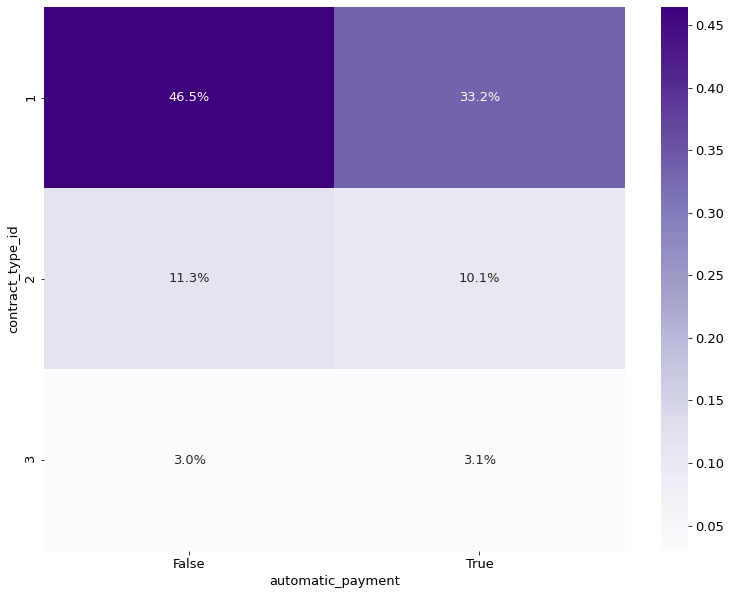

In [33]:
plt.rc('figure', figsize=(13, 10))
plt.rc('font', size=13)
ctab = pd.crosstab(train.contract_type_id, train.automatic_payment, values=train.churn, aggfunc='mean')
sns.heatmap(ctab, annot=True, cmap='Purples', fmt='.1%')

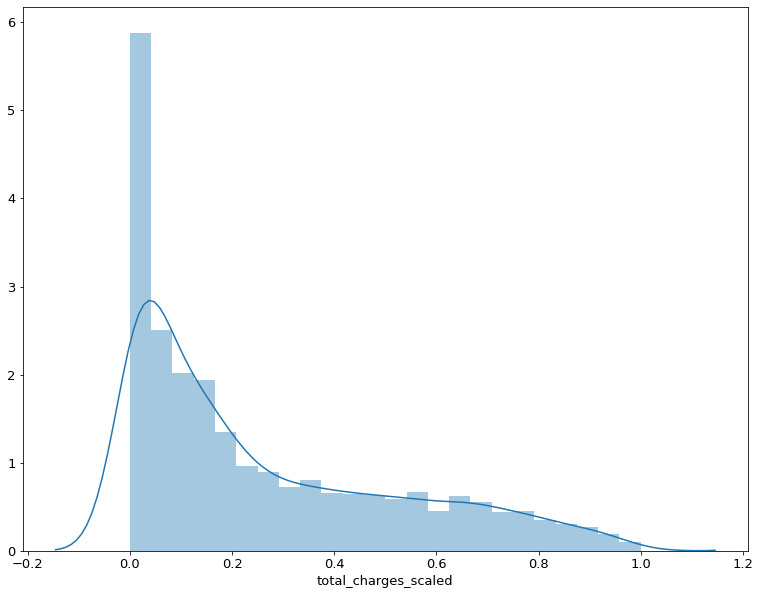

In [34]:
sns.distplot(train.total_charges_scaled)

In [35]:
train.groupby(['churn','contract_type_id']).total_charges.count()

churn  contract_type_id
0      1                   1919
       2                   1117
       3                   1421
1      1                   1421
       2                    133
       3                     45
Name: total_charges, dtype: int64

In [36]:
from math import sqrt
from scipy import stats
churn = train[train.churn == 1]

μ = df.total_charges.mean()
xbar = churn.total_charges.mean()
s = churn.total_charges.std()
n = churn.shape[0]
degf = n - 1
standard_error = s / sqrt(n)

t = (xbar - μ) / (s / sqrt(n))
t

-16.486624641999633

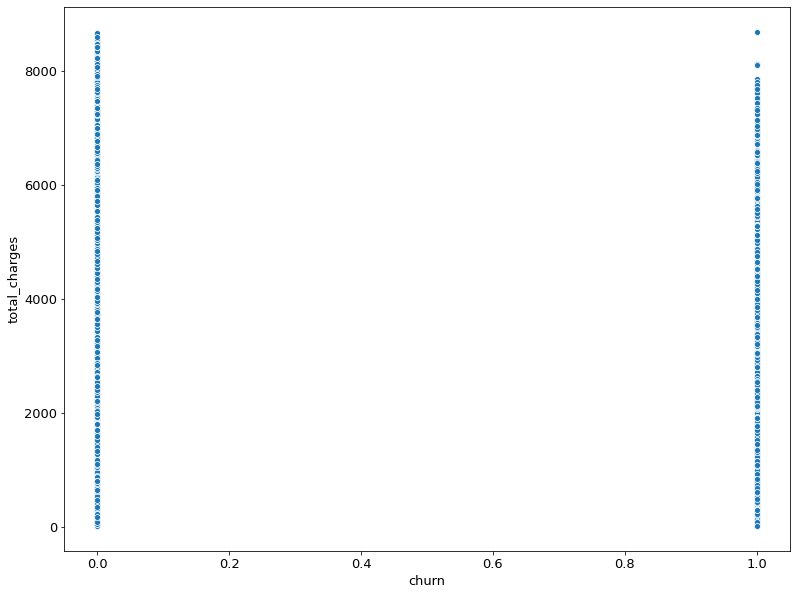

In [37]:
ax = sns.scatterplot(x="churn", y="total_charges", data = train)

In [38]:
train, validate = train_test_split(train, random_state=123, test_size=.2)


X_train = train[['senior_citizen', 'multiple_lines', 'streaming_tv', 'paperless_billing', 'contract_type_id', 'automatic_payment']]
y_train = train[['churn']]
X_val = validate[['senior_citizen', 'multiple_lines', 'streaming_tv', 'paperless_billing', 'contract_type_id', 'automatic_payment']]
y_val = validate[['churn']]
X_test = test[['senior_citizen', 'multiple_lines', 'streaming_tv', 'paperless_billing', 'contract_type_id', 'automatic_payment']]
y_test = test[['churn']]

In [39]:
logit = LogisticRegression(random_state = 123)
logit.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=123, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [40]:
y_pred = logit.predict(X_train)
y_pred[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [41]:
y_pred_proba = logit.predict_proba(X_train)

In [42]:
print('Accuracy of Logistic Regression classifier on training set: {:.2f}'
     .format(logit.score(X_train, y_train)))

Accuracy of Logistic Regression classifier on training set: 0.76


In [43]:
pd.DataFrame(confusion_matrix(y_train, y_pred))

,0,1
0,3338,245
1,940,321


In [44]:
model_df = train[['churn']]

In [45]:
model_df['logit_predictions'] = logit.predict(X_train)
y = logit.predict_proba(X_train)[:, 1]
model_df['probabilities'] = y
model_df.head()

,churn,logit_predictions,probabilities
1441,0,0,0.028396
4312,0,0,0.498224
6994,0,0,0.028396
278,0,0,0.326161
4575,1,0,0.433531


In [46]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.93      0.85      3583
           1       0.57      0.25      0.35      1261

    accuracy                           0.76      4844
   macro avg       0.67      0.59      0.60      4844
weighted avg       0.72      0.76      0.72      4844



### Decision tree classifier

In [47]:
clf = DecisionTreeClassifier(criterion='gini', max_depth=3, random_state=123)
clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

In [48]:
y_pred = clf.predict(X_train)
y_pred[0:5]

array([0, 1, 0, 0, 1])

In [49]:
y_pred_proba = clf.predict_proba(X_train)
y_pred_proba

array([[0.95300752, 0.04699248],
       [0.47766044, 0.52233956],
       [0.95300752, 0.04699248],
       ...,
       [0.94756554, 0.05243446],
       [0.70435967, 0.29564033],
       [0.70435967, 0.29564033]])

In [50]:
print('Accuracy of Decision Tree classifier on training set: {:.2f}'
     .format(clf.score(X_train, y_train)))

Accuracy of Decision Tree classifier on training set: 0.75


In [51]:
confusion_matrix(y_train, y_pred)

array([[2995,  588],
       [ 618,  643]])

In [52]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.84      0.83      3583
           1       0.52      0.51      0.52      1261

    accuracy                           0.75      4844
   macro avg       0.68      0.67      0.67      4844
weighted avg       0.75      0.75      0.75      4844



In [53]:
model_df['decision_tree_predictions'] = clf.predict(X_train)
x = clf.predict_proba(X_train)[:, 1]
model_df['dt_probabilities'] = x
model_df.head()

,churn,logit_predictions,probabilities,decision_tree_predictions,dt_probabilities
1441,0,0,0.028396,0,0.046992
4312,0,0,0.498224,1,0.522340
6994,0,0,0.028396,0,0.046992
278,0,0,0.326161,0,0.378119
4575,1,0,0.433531,1,0.522340


In [54]:
X_train1 = train[['senior_citizen', 'multiple_lines', 'streaming_tv', 'paperless_billing', 'contract_type_id', 'automatic_payment', 'total_charges_scaled']]
y_train1 = train[['churn']]
X_val1 = validate[['senior_citizen', 'multiple_lines', 'streaming_tv', 'paperless_billing', 'contract_type_id', 'automatic_payment', 'total_charges_scaled']]
y_val1 = validate[['churn']]
X_test1 = test[['senior_citizen', 'multiple_lines', 'streaming_tv', 'paperless_billing', 'contract_type_id', 'automatic_payment', 'total_charges_scaled']]
y_test1 = test[['churn']]

In [55]:
logit = LogisticRegression(random_state = 123)
logit.fit(X_train1, y_train1)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=123, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [56]:
y_pred1 = logit.predict(X_train1)
y_pred1[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [57]:
y_pred_proba1 = logit.predict_proba(X_train1)

In [58]:
print('Accuracy of Logistic Regression classifier on training set: {:.2f}'
     .format(logit.score(X_train1, y_train1)))

Accuracy of Logistic Regression classifier on training set: 0.77


In [59]:
print(classification_report(y_train1, y_pred1))

              precision    recall  f1-score   support

           0       0.80      0.92      0.86      3583
           1       0.61      0.34      0.44      1261

    accuracy                           0.77      4844
   macro avg       0.70      0.63      0.65      4844
weighted avg       0.75      0.77      0.75      4844



### Decision tree two

In [60]:
y_pred1 = clf.predict(X_train1)
y_pred1[0:5]

ValueError: Number of features of the model must match the input. Model n_features is 6 and input n_features is 7 

In [ ]:
y_pred_proba1 = clf.predict_proba(X_train1)
y_pred_proba1

In [ ]:
print('Accuracy of Decision Tree classifier on training set: {:.2f}'
     .format(clf.score(X_train1, y_train1)))

In [ ]:
confusion_matrix(y_train1, y_pred1)

In [ ]:
print(classification_report(y_train1, y_pred1))

In [ ]:
model_df['logit_predictions_2'] = logit.predict(X_train1)